# Introduction

### Problem Statement

Loan agreements are mostly uncategorized and having people review every contract manually limits productivity. Automating much of this process with a machine learning algorithm, companies can reduce both costs, and human error. I propose using Natural Language Processing to help review mortgage and loan contracts. It can sort them into categories depending on the language used in the contract. After it’s put into the appropriate category, the program can then pick out what parts of the contract needs to be reviewed by a person. 

### Executive Summary

Machine Learning and Natural Language Processing is a very powerful tool for making predictions with categorical data, using text. Finding subreddits with similar fandoms and terminology barely throws off the model. Most models are above 90% accuracy. The method is very good at pick out which words and word combinations are unique to a given document. Even when words that make classification easy are removed the algoirthm used can still find patterns in the texts and score high on accuracy. This makes them useful for sorting documents in a professional setting.

### Table of Contents:
- [Data Collection](#Data-Collection) 
- [Data Cleaning and EDA](#Data-Cleaning-and-EDA)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusion and Reccomendations](#Conclusion-and-Reccomendations)

# My Analysis

### Data Collection

In [1222]:
# Module Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns 
import requests
import time


from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marcj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1259]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [4]:
# Paramters make https request to r/anime for 100 posts
# The before parameter is left blank to be filled in by a function later
params1 = {
        'subreddit' : 'anime',
        'size' : 1000,
        'before': None
    
}

In [5]:
# Paramters make https request to r/manga for 100 posts

params2 = {
        'subreddit' : 'manga',
        'size' : 1000,
        'before': None
    
}

In [6]:
def stem_cleaner(comment):
    # Set token & instantiate Lem/Stem
    p_stemmer = PorterStemmer()
    my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+") 

    
    # split string into a word list in lower case
    words = my_tokenizer.tokenize(comment.lower())

    # remove stop words from list
    stop_word_list = stopwords.words('english')
    no_stops = [i for i in words if i not in stop_word_list]

    # Lemmatize each word in list 
    comm_stem = [p_stemmer.stem(i) for i in no_stops]

    # Put words back together
    return " ".join(comm_stem)

In [7]:
# list of 10 time Epochs for 11:00 P.M to 2:00 P.M at 1 hour intervals on October, 13 2021
# By getting posts in 1 hour increments into the past, each group of 100 posts should be different 
# based on how frequently people post on reddit
date_list = [1634137200, 
             1634133600, 
             1634130000, 
             1634126400, 
             1634122800, 
             1634119200, 
             1634115600, 
             1634112000, 
             1634108400, 
             1634104800]

In [8]:
# Function to pull 100 posts 10 times and a create a list of Dataframes
def The_DataframeMaker_1000(url, params):
    # Initialize list with 10 empty values to be filled later
    df_list = [None]*10
    
    for i in range(10): 
        # Https request using reddit api of subreddit given in params
        response = requests.get(url, params)
        # The Json file with dictionary of post data is saved
        data = response.json()
        # The Dataframe list variable is populated with the json data converted into a dataframe
        df_list[i] = pd.DataFrame(data['data'])
        # The before parameter for the get method is updated so data is pulled from 1 hour prior on each loop
        params['before'] = date_list[i]
        # Delay next loop for 5 seconds so not too many requests are made at once
        time.sleep(5)
    
    return df_list     

In [9]:
# Test of function to create a list of 10 dataframes with 100 posts each from r/anime
AnimeDataframeList = The_DataframeMaker_1000(url, params1)

In [10]:
# 1st dataframe on list
# each dataframe has information regarding how and when the author posted with 100 posts
AnimeDataframeList[0]

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,preview,secure_media,secure_media_embed,thumbnail_height,thumbnail_width,url_overridden_by_dest,media_metadata,removed_by_category,author_flair_background_color,author_flair_text_color
0,[],False,AutoLovepon,None,[],None,text,t2_1jzq3sy,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Locke349,None,[],None,text,t2_942t6mn4,False,False,...,"{'enabled': False, 'images': [{'id': 'U6qFPAmD...","{'oembed': {'author_name': 'Locke Piano', 'aut...","{'content': '&lt;iframe width=""356"" height=""20...",105.0,140.0,https://youtu.be/4NKiU0gENfk,NaN,NaN,NaN,NaN
2,[],False,animemux,None,[],None,text,t2_8no7a1qr,False,False,...,"{'enabled': False, 'images': [{'id': 'xLpMT0GO...",NaN,NaN,78.0,140.0,https://www.animemux.com/2021/10/anime%20chara...,NaN,NaN,NaN,NaN
3,[],False,AriiXion,None,[],None,text,t2_8n8ksjno,False,False,...,"{'enabled': False, 'images': [{'id': 'KM4hF0yT...","{'oembed': {'author_name': 'Brian Loh', 'autho...","{'content': '&lt;iframe width=""356"" height=""20...",105.0,140.0,https://youtu.be/tAzq6RJKudQ,NaN,NaN,NaN,NaN
4,[],False,Arsenio1991,None,[],None,text,t2_y7if2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,[],False,Acrillo,None,[],None,text,t2_1xfhtmne,False,False,...,"{'enabled': True, 'images': [{'id': 'k0rvoFLp-...",NaN,NaN,140.0,140.0,https://i.redd.it/wjg6vgxt2zt71.jpg,NaN,NaN,NaN,NaN
96,[],False,Acrillo,None,[],None,text,t2_1xfhtmne,False,False,...,"{'enabled': True, 'images': [{'id': '3ZAWe4-5h...",NaN,NaN,140.0,140.0,https://i.redd.it/a06a7dud2zt71.jpg,NaN,NaN,NaN,NaN
97,[],False,eddyto,None,[],None,text,t2_114la9,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,[],False,Acrillo,None,[],None,text,t2_1xfhtmne,False,False,...,"{'enabled': True, 'images': [{'id': '3wFJhLxjm...",NaN,NaN,140.0,140.0,https://i.redd.it/wdqs0m451zt71.jpg,NaN,NaN,NaN,NaN


In [11]:
#combine all 10 dataframes into 1 dataframe 1000 with posts of data
df_anime = pd.concat([AnimeDataframeList[i] for i in range(10)])
# Reset index to go from 0 to 497
df_anime.reset_index(inplace=True)
df_anime

,index,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,...,secure_media,secure_media_embed,thumbnail_height,thumbnail_width,url_overridden_by_dest,media_metadata,removed_by_category,author_flair_background_color,author_flair_text_color,author_flair_template_id
0,0,[],False,AutoLovepon,None,[],None,text,t2_1jzq3sy,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,Locke349,None,[],None,text,t2_942t6mn4,False,...,"{'oembed': {'author_name': 'Locke Piano', 'aut...","{'content': '&lt;iframe width=""356"" height=""20...",105.0,140.0,https://youtu.be/4NKiU0gENfk,NaN,NaN,NaN,NaN,NaN
2,2,[],False,animemux,None,[],None,text,t2_8no7a1qr,False,...,NaN,NaN,78.0,140.0,https://www.animemux.com/2021/10/anime%20chara...,NaN,NaN,NaN,NaN,NaN
3,3,[],False,AriiXion,None,[],None,text,t2_8n8ksjno,False,...,"{'oembed': {'author_name': 'Brian Loh', 'autho...","{'content': '&lt;iframe width=""356"" height=""20...",105.0,140.0,https://youtu.be/tAzq6RJKudQ,NaN,NaN,NaN,NaN,NaN
4,4,[],False,Arsenio1991,None,[],None,text,t2_y7if2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,95,[],False,kuukuni,None,[],None,text,t2_ff37whq1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,96,[],False,iiitme,None,[],None,text,t2_18bentkq,False,...,NaN,NaN,NaN,NaN,NaN,NaN,moderator,NaN,NaN,NaN
997,97,[],False,Heiwbs,None,[],None,text,t2_drfvz15j,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,98,[],False,Bagutte_Farsi_21,None,[],None,text,t2_4a3xeeet,False,...,NaN,NaN,NaN,NaN,NaN,NaN,moderator,NaN,NaN,NaN


There are a lot of NaN values.
<br> However the subreddit, selftext, and title are the most important columns and they all contain information.

In [12]:
# The three columns to be used for my model mostly have information in them
df_anime[['subreddit', 'selftext', 'title']]

,subreddit,selftext,title
0,anime,"*Mieruko-chan*, episode 3\n\n\n\n# [Rate this ...",Mieruko-chan - Episode 3 discussion
1,anime,,〘Its Too Late〙86 Eighty Six ~ Episode 13 Seaso...
2,anime,,Top 10 Anime Characters That Never Lose
3,anime,,Made a short orchestral cover of 'takt' from T...
4,anime,I consider myself to be a veteran when it come...,Any recommendations animes that are actually g...
...,...,...,...
995,anime,"need suggestions for good anime, the last time...",suggestions because I want to feel alive again
996,anime,[removed],Good romance anime’s on hulu
997,anime,After finishing Death Note I’m struggling to f...,I don’t know what anime to watch next.
998,anime,[removed],"Animes like ""You"""


In [13]:
df_anime[df_anime['title']=='']

,index,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,...,secure_media,secure_media_embed,thumbnail_height,thumbnail_width,url_overridden_by_dest,media_metadata,removed_by_category,author_flair_background_color,author_flair_text_color,author_flair_template_id


There is missing data in the selftext column, however the text column seems to always contain information.

To make things easier I will use a function to create the dataframes with 1000 rows each from both r/anime and r/mange

In [14]:
# Function to take comments and collect them into an organized Dataframe
def Dataframe_organizer_2000(url, params1, params2):
    # A list for parameters for r/anime and r/manga
    p_list = [params1, params2]
    # a list to hold two dataframe lists, it is initialized with two empty slots
    final_list = [None]*2
    # final list is populated with two dataframe lists with 1000 rows each using previous dataframe function
    for i in range(2):
        final_list[i] = The_DataframeMaker_1000(url, p_list[i])
    # the two dataframe lists are combined into 1 list with 2000 posts
    final_list = final_list[0] + final_list[1]
    # all rows on dataframe list are combined into one large dataframe
    df = pd.concat([final_list[i] for i in range(len(final_list))])
    # only the subreddit, selftext, and title columns will be used for modeling the others are dropped
    df = df[['subreddit', 'selftext', 'title']]
    # rows with missing data in the selftext column are dropped
    df = df[df['selftext'] != '']
    df = df[df['selftext'] != '[removed]']
    df = df[df['selftext'] != '[deleted]']
    # rows with missing data is dropped
    df.dropna(inplace=True)
    # index is reset to go from 0 until the last numbered row
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

In [19]:
# uses functions to create dataframe of 1000 rows each from the two subreddits given in the parameters
df = Dataframe_organizer_2000(url, params1, params2)

In [18]:
# change target column to numeric values, 1 for anime, 0 for manga
df['subreddit'] = np.where(df['subreddit']=='anime', 1, 0)

In [27]:
# Save dataframe to work with it later.
# df.to_csv('./anime_manga_755.csv')

In [742]:
df = pd.read_csv('./anime_manga_755.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [743]:
df

,subreddit,selftext,title
0,1,"I don't know the title, but i know that the op...",Looking for an anime
1,1,Usually they have it on there heads but does a...,Anyone know a anime with characters with a sym...
2,1,Here's my Mal list for some reference.\nhttps:...,I'm bored and am looking for some anime to wat...
3,1,"Hey guys, a few years ago I watched a harem an...",Searching for an anime
4,1,Dm me or sumn in need,I need an anime site
...,...,...,...
750,0,&amp;#x200B;\n\n[I remember it was like hashor...,What was the name of this manga again?
751,0,Looking for another manga to read and oregairu...,Romcom manga with a love triangle like oregairu?
752,0,Are there any manga where the mc has a girl or...,need manga suggestions like this
753,0,Third time posting this first two didn’t get a...,Can you help me find this manga that I only kn...


The dataframe has far less than 2000 rows, because of all the missing data in selftext which was removed. <br>
Otherwsise the dataframe has the information expected so I will start cleaning and preparing for modeling.

### Data Cleaning and EDA

In [55]:
# No missing data as the function has removed it.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  755 non-null    int64 
 1   selftext   755 non-null    object
 2   title      755 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.8+ KB


In [734]:
# Average of anime message lengths
df.iloc[0:412,:]['selftext'].map(len).mean()

270.8373786407767

In [735]:
df.iloc[413:754,:]['selftext'].map(len).mean()

373.5953079178886

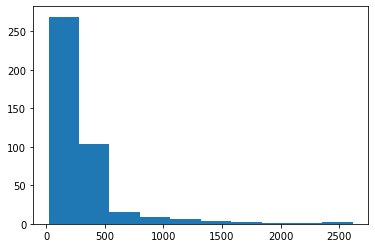

In [736]:
# distribution of post lenth for r/anime
plt.hist(df.iloc[0:412,:]['selftext'].map(len));

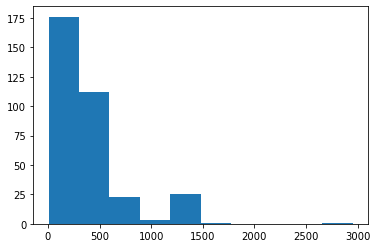

In [737]:
# distribution of post lenth for r/manga
plt.hist(df.iloc[413:754,:]['selftext'].map(len));

The dataframe is ready for Preprocessing

### Preprocessing and Modeling

#### baseline model

In [56]:
#The target data is mostly balanced. A null model has an accuracy of 54.7%
df['subreddit'].value_counts(normalize=True)

1    0.54702
0    0.45298
Name: subreddit, dtype: float64

#### Cleaning

I Will use code for function to split words, remove stop words, and eliminate inflected forms of a word. <br>
I will try both lemmatizing and stemming the words and compare modeling scores.

In [21]:
# Code to lemmatize and remove stop words. Originally by Katie Sylvia
def lem_cleaner(comment):
    # Set token & instantiate Lem
    lemmatizer = WordNetLemmatizer()
    my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+") 

    
    # split string into a word list in lower case
    words = my_tokenizer.tokenize(comment.lower())

    # remove stop words from list
    stop_word_list = stopwords.words('english')
    no_stops = [i for i in words if i not in stop_word_list]

    # Lemmatize each word in list 
    comm_lem = [lemmatizer.lemmatize(i) for i in no_stops]

    # Put words back together
    return " ".join(comm_lem)

In [22]:
# Code to stem and remove stop words. Originally by Katie Sylvia
def stem_cleaner(comment):
    # Set token & instantiate Stem
    p_stemmer = PorterStemmer()
    my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+") 

    
    # split string into a word list in lower case
    words = my_tokenizer.tokenize(comment.lower())

    # remove stop words from list
    stop_word_list = stopwords.words('english')
    no_stops = [i for i in words if i not in stop_word_list]

    # stem each word in list 
    comm_stem = [p_stemmer.stem(i) for i in no_stops]

    # Put words back together
    return " ".join(comm_stem)

The lemmatizer function removes inflected words and and special characters so input data is more useful for modeling as demonstrated below

In [23]:
# text from first post in the dataframe
df['selftext'][0]

'I don\'t know the title, but i know that the opening song has the main characters singing about what role they are going to play in an online game or something. A voice suggests a role (tank, healer, DPS, or something) and then they sing "nai. nai. nai-nai-nai-nai" 2 or 3 times in a row.\n\nIf anybody knows the anime, would very much appreciate a pointer. Thanks in advance!'

In [24]:
# text from first post after lemmatizer
lem_cleaner(df['selftext'][0])

'know title know opening song main character singing role going play online game something voice suggests role tank healer dp something sing nai nai nai nai nai nai 2 3 time row anybody know anime would much appreciate pointer thanks advance'

In [758]:
# 10 most common words in r/anime
Counter(" ".join(df_lem.iloc[0:412,:]["selftext"]).split()).most_common(10)

[('anime', 415),
 ('http', 226),
 ('watch', 143),
 ('like', 142),
 ('one', 110),
 ('character', 99),
 ('would', 82),
 ('show', 78),
 ('com', 74),
 ('know', 72)]

In [1175]:
# variables representint 10 most commin words in r/anime and their frequency
anime_words = [word[0] for word in Counter(" ".join(df_lem.iloc[0:412,:]["selftext"]).split()).most_common(10)]
anime_counts = [word[1] for word in Counter(" ".join(df_lem.iloc[0:412,:]["selftext"]).split()).most_common(10)]

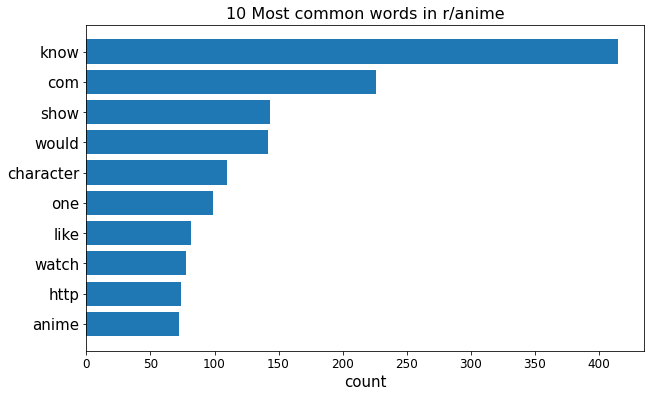

In [1176]:
# plot of 10 most frequen r/anime words
plt.figure(figsize=(10,6))
plt.barh(anime_words, sorted(anime_counts))
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('count', fontsize=15)
plt.title('10 Most common words in r/anime', fontsize=16);

In [760]:
# 10 most common words in r/manmga
Counter(" ".join(df_lem.iloc[413:754,:]["selftext"]).split()).most_common(10)

[('manga', 251),
 ('one', 148),
 ('girl', 141),
 ('guy', 133),
 ('know', 125),
 ('like', 113),
 ('chapter', 110),
 ('read', 109),
 ('remember', 107),
 ('time', 97)]

In [1177]:
# variables representint 10 most commin words in r/anime and their frequency
manga_words = [word[0] for word in Counter(" ".join(df_lem.iloc[413:754,:]["selftext"]).split()).most_common(10)]
manga_counts = [word[1] for word in Counter(" ".join(df_lem.iloc[413:754,:]["selftext"]).split()).most_common(10)]

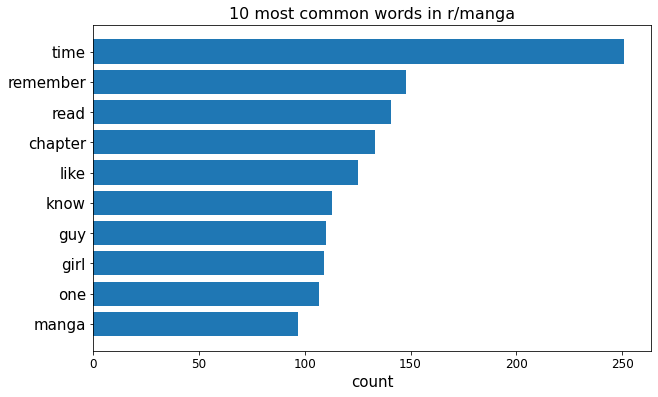

In [1173]:
plt.figure(figsize=(10,6))
plt.barh(manga_words, sorted(manga_counts))
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('count', fontsize=15)
plt.title('10 most common words in r/manga', fontsize=16);

In [1178]:
# function to return a list of bigrams in a string of text
def bigrammer(text):
    # split string into a list of words
    tl = text.split()
    # returns a lit of each successive group of two words from original list
    return [tl[i-1] + " " + tl[i] for i in range(1,len(tl))]

In [1179]:
# Creates new column called Bigrams with bigrams using the selftext column 
df_lem['Bigrams'] = (df_lem['title'] + " " + df_lem['selftext']).map(bigrammer)

In [1028]:
df_lem.head()

,subreddit,selftext,title,Bigrams
0,1,know title know opening song main character si...,looking anime,"[looking anime, anime know, know title, title ..."
1,1,usually head character chest,anyone know anime character symbol chest simil...,"[anyone know, know anime, anime character, cha..."
2,1,here's mal list reference http myanimelist net...,i'm bored looking anime watch keep going,"[i'm bored, bored looking, looking anime, anim..."
3,1,hey guy year ago watched harem anime character...,searching anime,"[searching anime, anime hey, hey guy, guy year..."
4,1,dm sumn need,need anime site,"[need anime, anime site, site dm, dm sumn, sum..."


In [1037]:
# code from https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
# finds most frequent occurence of wors in a list of words 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [1046]:
# Creat column of most frequent bigrams
df_lem['Most frequent Bigram']=df_lem['Bigrams'].map(most_frequent)

In [1051]:
#most common word pair n r/anime
most_frequent(df_lem.iloc[0:412,:]['Most frequent Bigram'])

'violet evergarden'

In [1053]:
#most common word pair in r/manga
most_frequent(df_lem.iloc[413:754,:]['Most frequent Bigram'])

'manga like'

In [1070]:
# Loop to find most frequen anime bigrams
anime_bigrams = []
for i in df_lem.iloc[0:412]['Most frequent Bigram']:
    anime_bigrams.append(i)
    

In [1071]:
anime_bigrams

['nai nai',
 'anyone know',
 "i'm bored",
 'searching anime',
 'need anime',
 'spoiled death',
 'ridiculously op',
 'good yaoi',
 'massive crush',
 "news 'vampire",
 'lesbian anime',
 'love story',
 'character progression',
 'dont think',
 'watch next',
 'http myanimelist',
 'komi san',
 'op mc',
 'anime like',
 'anime think',
 'platform watch',
 'new season',
 'way watch',
 'cowboy bebop',
 'mad man',
 'sword art',
 'noucome episode',
 'need help',
 'play role',
 'suggestion want',
 'death note',
 'amp x200b',
 'attack titan',
 'better ruler',
 'anime dont',
 'baki need',
 'anime list',
 'better written',
 'opinion theme',
 'watch aot',
 'place universe',
 'place universe',
 'naruto one',
 'anime like',
 'watch watched',
 'anime de',
 'watch watch',
 'need seasonal',
 'indra ashura',
 'help finding',
 'thought aquatope',
 'finest assassin',
 'haikyuu top',
 "aot's trailer",
 'using quirk',
 'anyone suggestion',
 'anime subreddit',
 'really fun',
 'time got',
 'horniest anime',
 'shin 

In [1072]:
#list of tupes of most common anime bigrams and their count
c = Counter(anime_bigrams)
c.most_common(10)

[('violet evergarden', 12),
 ('time got', 9),
 ('anime character', 7),
 ('anime computer', 7),
 ('question anyone', 7),
 ('good anime', 7),
 ('saiki k', 7),
 ('furare girl', 7),
 ('original japanese', 7),
 ('otome sensou', 7)]

In [1073]:
#List of all manga most frequen bigrams
manga_bigrams = []
for i in df_lem.iloc[413:754]['Most frequent Bigram']:
    manga_bigrams.append(i)
    

In [1092]:
c = Counter(anime_bigrams)

In [1093]:
#dictionary of anime bigram and frequency
a_dict = dict(c.most_common(10))
a_dict

{'violet evergarden': 12,
 'time got': 9,
 'anime character': 7,
 'anime computer': 7,
 'question anyone': 7,
 'good anime': 7,
 'saiki k': 7,
 'furare girl': 7,
 'original japanese': 7,
 'otome sensou': 7}

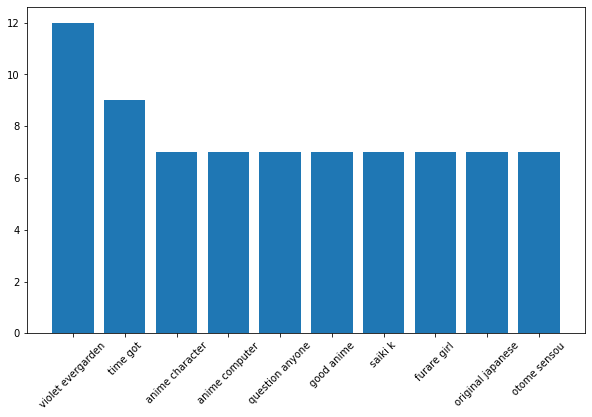

In [1131]:
#plot of anime bigram frequency using dictionary
plt.figure(figsize=(10,6))
plt.bar(a_dict.keys(), a_dict.values())
plt.xticks(rotation=45);

In [ ]:
c = Counter(manga_bigrams)

In [1080]:
# list of tuples of most common manga bigrams and  frequency
m_dict = dict(c.most_common(10))
m_dict

{'manga like': 17,
 'looking manga': 14,
 'goth guy': 13,
 'anyone know': 10,
 'need help': 9,
 'help finding': 9,
 'open portal': 9,
 'manga title': 9,
 'specific manga': 8,
 'furare girl': 8}

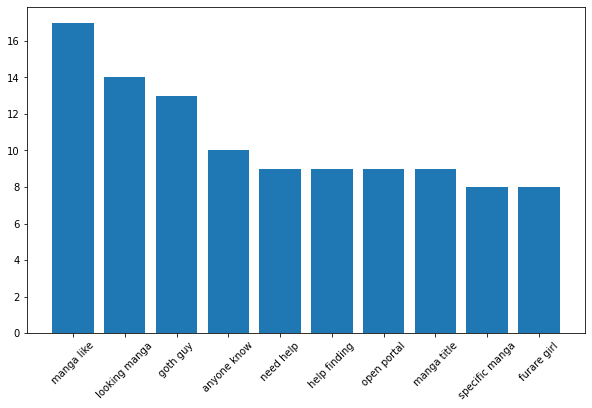

In [1180]:
# Plot of manga bigram frequency
plt.figure(figsize=(10,6))
plt.bar(m_dict.keys(), m_dict.values())
plt.xticks(rotation=45);

# Modeling

In [25]:
# Function to evaluate accuracy of models using variable, target, word transformer, and an estimator
def classifier_test(transformer, classifier, X, y):
    # instantiate pipeline using passed text transformer and estimator
    pipe = make_pipeline(transformer, classifier)
    # Train test split X and y data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    # the pipeline is fit to training data.
    pipe.fit(X_train, y_train)
    # prediction for target using test data
    preds = pipe.predict(X_test)
    # Accuracy score calculated with score method
    Acc = pipe.score(X_test, y_test)
    # F1 score calculated
    F1 = f1_score(y_test, preds)
    # Balanced accuracy is calculated
    BA = balanced_accuracy_score(y_test, preds)
    # Results are printed and returned to user
    return f"Accuracy is {Acc}, F1 Score is {F1}, Balanced Accuracy is {BA}"
    

Countvectorizer, and Tfidfvecotroizer are used with different classifiers to model and predict the subreddit category
using the input text data. <br> the results are calculated and printed using the classifier function using the following 7 classifiers. 
- Gradient Boost 
- Bagging 
- Random Forest 
- Extra Trees 
- Naive Bayes 
- Logistic Regression  

I will use a gridsearch to fine-tune the pipeline combination with the highest score. <br>
I will evalautes scores using Stemmed, Lemmatized, and uncleaned input data. First I will evaluate models with data cleaned with word stemmer

### Stemmed Data Scores

---

In [744]:
# state new dataframe with stemmed words
df_stem = df.copy()
# apply stemming function to data selftext column
df_stem['selftext'] = df_stem['selftext'].map(stem_cleaner)
# apply stemming function to data title column
df_stem['title'] = df_stem['title'].map(stem_cleaner)

In [58]:
# stemmed X data is text in title column plus text in selftext column
X_stem = df_stem['title'] + " " + df_stem['selftext']
# target is which subreddit text originates from, 1 for r/anime, 0 for r/manga
y = df['subreddit']

#### Gradient Boost

In [44]:
classifier_test(CountVectorizer(max_features = 1000), GradientBoostingClassifier(), X_stem, y)

'Accuracy is 0.9470899470899471, F1 Score is 0.9523809523809522, Balanced Accuracy is 0.9447392187852788'

In [45]:
classifier_test(TfidfVectorizer(max_features=1000), GradientBoostingClassifier(), X_stem, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9809523809523809, Balanced Accuracy is 0.9767441860465116'

#### Bagging

In [46]:
classifier_test(TfidfVectorizer(max_features=1000), BaggingClassifier(n_estimators=1_000), X_stem, y)

'Accuracy is 0.9523809523809523, F1 Score is 0.9565217391304348, Balanced Accuracy is 0.9515127568299842'

In [47]:
classifier_test(CountVectorizer(max_features = 1000), BaggingClassifier(n_estimators=1_000), X_stem, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.9751243781094527, Balanced Accuracy is 0.9757281553398058'

#### Random Forest

In [48]:
classifier_test(CountVectorizer(max_features = 1000), RandomForestClassifier(), X_stem, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9809523809523809, Balanced Accuracy is 0.9767441860465116'

In [49]:
classifier_test(TfidfVectorizer(max_features=1000), RandomForestClassifier(), X_stem, y)

'Accuracy is 0.9841269841269841, F1 Score is 0.9853658536585367, Balanced Accuracy is 0.9844773086475502'

#### Extra Trees

In [51]:
classifier_test(CountVectorizer(max_features = 1000), ExtraTreesClassifier(), X_stem, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.9716981132075472, Balanced Accuracy is 0.9651162790697674'

In [52]:
classifier_test(TfidfVectorizer(max_features=1000), ExtraTreesClassifier(), X_stem, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.970873786407767, Balanced Accuracy is 0.9679950327387672'

#### Naive Bayes

In [53]:
classifier_test(CountVectorizer(max_features = 1000), MultinomialNB(), X_stem, y)

'Accuracy is 0.9576719576719577, F1 Score is 0.9607843137254902, Balanced Accuracy is 0.9582862948746895'

In [54]:
classifier_test(TfidfVectorizer(max_features=1000), MultinomialNB(), X_stem, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.970873786407767, Balanced Accuracy is 0.9679950327387672'

#### Logistic Regression

In [55]:
classifier_test(CountVectorizer(max_features = 1000), LogisticRegression(), X_stem, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.976303317535545, Balanced Accuracy is 0.9709302325581395'

In [56]:
classifier_test(TfidfVectorizer(max_features=1000), LogisticRegression(), X_stem, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9805825242718447, Balanced Accuracy is 0.9786633551591781'

### Lemmatized Data

In [746]:
# state new dataframe with stemmed words
df_lem = df.copy()
# apply stemming function to data selftext column
df_lem['selftext'] = df_lem['selftext'].map(lem_cleaner)
# apply stemming function to data title column
df_lem['title'] = df_lem['title'].map(lem_cleaner)

In [60]:
# Lemmatized X data is text in title column plus text in selftext column
X_lem = df_lem['title'] + " " + df_lem['selftext']
# target is which subreddit text originates from, 1 for r/anime, 0 for r/manga
y = df['subreddit']

#### Gradient Boost

In [62]:
classifier_test(CountVectorizer(max_features = 1000), GradientBoostingClassifier(), X_lem, y)

'Accuracy is 0.9841269841269841, F1 Score is 0.9855072463768114, Balanced Accuracy is 0.983517724091217'

In [63]:
classifier_test(TfidfVectorizer(max_features=1000), GradientBoostingClassifier(), X_lem, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.9751243781094527, Balanced Accuracy is 0.9757281553398058'

#### Bagging

In [64]:
classifier_test(CountVectorizer(max_features = 1000), BaggingClassifier(), X_lem, y)

'Accuracy is 0.9629629629629629, F1 Score is 0.966183574879227, Balanced Accuracy is 0.9621810792503951'

In [65]:
classifier_test(TfidfVectorizer(max_features=1000), BaggingClassifier(), X_lem, y)

'Accuracy is 0.9894179894179894, F1 Score is 0.9902912621359223, Balanced Accuracy is 0.9893316775795891'

#### Random Forest

In [66]:
classifier_test(CountVectorizer(max_features = 1000), RandomForestClassifier(), X_lem, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.9705882352941178, Balanced Accuracy is 0.9689546172951005'

In [67]:
classifier_test(TfidfVectorizer(max_features=1000), RandomForestClassifier(), X_lem, y)

'Accuracy is 0.9894179894179894, F1 Score is 0.9901960784313726, Balanced Accuracy is 0.9902912621359223'

#### Extra Trees

In [68]:
classifier_test(CountVectorizer(max_features = 1000), ExtraTreesClassifier(), X_lem, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9803921568627452, Balanced Accuracy is 0.9796229397155114'

In [69]:
classifier_test(TfidfVectorizer(max_features=1000), ExtraTreesClassifier(), X_lem, y)

'Accuracy is 0.9629629629629629, F1 Score is 0.9658536585365853, Balanced Accuracy is 0.9631406638067284'

#### Naive Bayes

In [70]:
classifier_test(CountVectorizer(max_features = 1000), MultinomialNB(), X_lem, y)

'Accuracy is 0.9365079365079365, F1 Score is 0.941747572815534, Balanced Accuracy is 0.9359900654775344'

In [71]:
classifier_test(TfidfVectorizer(max_features=1000), MultinomialNB(), X_lem, y)

'Accuracy is 0.91005291005291, F1 Score is 0.9186602870813397, Balanced Accuracy is 0.9078798825920072'

#### Lostistic Regression

In [72]:
classifier_test(CountVectorizer(max_features = 1000), LogisticRegression(), X_lem, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.9753694581280788, Balanced Accuracy is 0.9747685707834726'

In [73]:
classifier_test(TfidfVectorizer(max_features=1000), LogisticRegression(), X_lem, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9805825242718447, Balanced Accuracy is 0.9786633551591781'

### Uncleaned Data

In [796]:
# Uncleaned X data is text in title column plus text in selftext column
X = df['title'] + " " + df['selftext']
# target is which subreddit text originates from, 1 for r/anime, 0 for r/manga
y = df['subreddit']

#### Gradient Boost

In [797]:
classifier_test(CountVectorizer(max_features = 1000), GradientBoostingClassifier(), X, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.9753694581280788, Balanced Accuracy is 0.9747685707834726'

In [798]:
classifier_test(TfidfVectorizer(max_features=1000), GradientBoostingClassifier(), X, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.9753694581280788, Balanced Accuracy is 0.9747685707834726'

#### Bagging

In [799]:
classifier_test(CountVectorizer(max_features = 1000), BaggingClassifier(), X, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9801980198019802, Balanced Accuracy is 0.9805825242718447'

In [800]:
classifier_test(TfidfVectorizer(max_features=1000), BaggingClassifier(), X, y)

'Accuracy is 0.9841269841269841, F1 Score is 0.9852216748768473, Balanced Accuracy is 0.9854368932038835'

#### Random Forest

In [801]:
classifier_test(CountVectorizer(max_features = 1000), RandomForestClassifier(), X, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.970873786407767, Balanced Accuracy is 0.9679950327387672'

In [802]:
classifier_test(TfidfVectorizer(max_features=1000), RandomForestClassifier(), X, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.970873786407767, Balanced Accuracy is 0.9679950327387672'

#### Extra Trees

In [803]:
classifier_test(CountVectorizer(max_features = 1000), ExtraTreesClassifier(), X, y)

'Accuracy is 0.9629629629629629, F1 Score is 0.9665071770334929, Balanced Accuracy is 0.9612214946940618'

In [804]:
classifier_test(TfidfVectorizer(max_features=1000), ExtraTreesClassifier(), X, y)

'Accuracy is 0.9788359788359788, F1 Score is 0.9805825242718447, Balanced Accuracy is 0.9786633551591781'

#### Naive Bayes

In [805]:
classifier_test(CountVectorizer(max_features = 1000), MultinomialNB(), X, y)

'Accuracy is 0.9365079365079365, F1 Score is 0.9433962264150944, Balanced Accuracy is 0.9331113118085347'

In [806]:
classifier_test(TfidfVectorizer(max_features=1000), MultinomialNB(), X, y)

'Accuracy is 0.9417989417989417, F1 Score is 0.9468599033816425, Balanced Accuracy is 0.9408444344095732'

#### Lostistic Regression

In [807]:
classifier_test(CountVectorizer(max_features = 1000), LogisticRegression(), X, y)

'Accuracy is 0.9682539682539683, F1 Score is 0.970873786407767, Balanced Accuracy is 0.9679950327387672'

In [808]:
classifier_test(TfidfVectorizer(max_features=1000), LogisticRegression(), X, y)

'Accuracy is 0.9735449735449735, F1 Score is 0.975609756097561, Balanced Accuracy is 0.9738089862271393'

## GridSearch

### Extremely Random Trees

In [1182]:
# instantiate pipeline for Gridsearch with countvectorizer and extratrees
tree_pipe = make_pipeline(CountVectorizer(max_features = 1000), ExtraTreesClassifier())

In [1183]:
# show paramters to use with gridsearch
# tree_pipe.get_params()

In [1191]:
# train test split on clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [1185]:
# Hyper-parameter tuning for countevectorizer and extratrees in gridsearch
tree_params = { 
                'countvectorizer__max_df': (0.5, 0.75, 1.0),
                'countvectorizer__max_features': (None, 5000, 10000, 50000),
                'countvectorizer__stop_words': [None, 'english'],
                'extratreesclassifier__n_estimators' : [50, 100, 200],
                'extratreesclassifier__max_depth' : [5, 10, 20, None],
                'extratreesclassifier__max_features' : ['auto','sqrt','log2'],
                'extratreesclassifier__warm_start' : [True, False]
}

In [1186]:
# instantiate grid search for the Extra Trees pipeline, fit and training data, and score on test data
gs_tree = GridSearchCV(tree_pipe, tree_params)

In [1187]:
gs_tree.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=1000)),
                                       ('extratreesclassifier',
                                        ExtraTreesClassifier())]),
             param_grid={'countvectorizer__max_df': (0.5, 0.75, 1.0),
                         'countvectorizer__max_features': (None, 5000, 10000,
                                                           50000),
                         'countvectorizer__stop_words': [None, 'english'],
                         'extratreesclassifier__max_depth': [5, 10, 20, None],
                         'extratreesclassifier__max_features': ['auto', 'sqrt',
                                                                'log2'],
                         'extratreesclassifier__n_estimators': [50, 100, 200],
                         'extratreesclassifier__warm_start': [True, False]})

In [1192]:
gs_tree.score(X_test, y_test)

0.9894179894179894

In [1193]:
# pipeline Hyper-parameters that give best result according to Grid Search
gs_tree.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': None,
 'countvectorizer__stop_words': 'english',
 'extratreesclassifier__max_depth': None,
 'extratreesclassifier__max_features': 'auto',
 'extratreesclassifier__n_estimators': 50,
 'extratreesclassifier__warm_start': False}

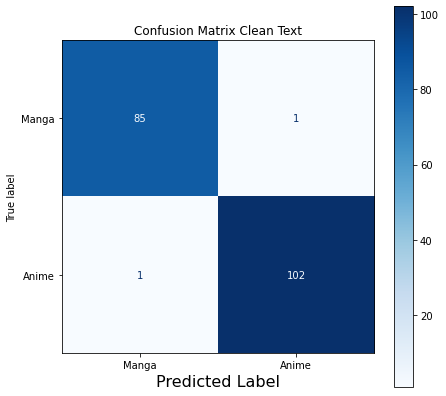

In [1194]:
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_estimator(gs_tree, X_test, y_test, display_labels = ['Manga', 'Anime'], cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix Clean Text")
plt.xlabel('Predicted Label', fontsize=16)
plt.show()

The extra trees model had an accuracy of about 99%. The confusion matrix shows only one false positive and one false negative.

### Decision Tree Ensemble

In [1195]:
# instantiate pipeline for Gridsearch with tfidfvectorizer and baggingclassifier
bag_pipe = make_pipeline(TfidfVectorizer(), BaggingClassifier())

In [1196]:
# bag_pipe.get_params()

In [1205]:
X_lem_train, X_lem_test, y_lem_train, y_lem_test = train_test_split(X_lem, y, stratify=y)

In [1198]:
# Hyper-parameter tuning for countevectorizer and extratrees in gridsearch
bag_params = {'tfidfvectorizer__max_features': [None, 5000, 10000, 50000],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidfvectorizer__max_df': [0.5, 0.75, 1.0],
              'baggingclassifier__max_samples': [0.5, 0.7, 1.0],
              'baggingclassifier__bootstrap_features': [False, True],
              'baggingclassifier__max_features': [0.5, 0.7, 1.0],
              'baggingclassifier__n_estimators': [2, 5, 10, 20],
              'baggingclassifier__warm_start': [True, False]
}

In [1199]:
gs_bag = GridSearchCV(bag_pipe, bag_params)

In [1200]:
gs_bag.fit(X_lem_train, y_lem_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('baggingclassifier',
                                        BaggingClassifier())]),
             param_grid={'baggingclassifier__bootstrap_features': [False, True],
                         'baggingclassifier__max_features': [0.5, 0.7, 1.0],
                         'baggingclassifier__max_samples': [0.5, 0.7, 1.0],
                         'baggingclassifier__n_estimators': [2, 5, 10, 20],
                         'baggingclassifier__warm_start': [True, False],
                         'tfidfvectorizer__max_df': [0.5, 0.75, 1.0],
                         'tfidfvectorizer__max_features': [None, 5000, 10000,
                                                           50000],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [439]:
gs_bag.score(X_lem_test, y_lem_test)

1.0

This Grid Search again seems to have no effect or a slightly positive one. The accuracy score is within percentage points of the default hyper-paramter score, however it is the first score of 100% accuracy. 

In [1201]:
# Hyper-paremters found by Grid Search
gs_bag.best_params_

{'baggingclassifier__bootstrap_features': True,
 'baggingclassifier__max_features': 1.0,
 'baggingclassifier__max_samples': 1.0,
 'baggingclassifier__n_estimators': 5,
 'baggingclassifier__warm_start': True,
 'tfidfvectorizer__max_df': 0.75,
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__ngram_range': (1, 3)}

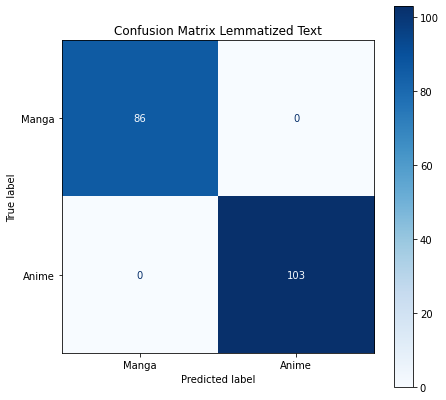

In [438]:
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_estimator(gs_bag, X_lem_test, y_test, display_labels = ['Manga', 'Anime'], cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix Lemmatized Text")
plt.show()

### Comparison  to Naive Bayes Method

In [460]:
# Pipeline from best naive bayes score from the scoring section
NB_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [812]:
# NB_pipeline.get_params()

In [462]:
NB_params = {'multinomialnb__alpha' : [0.5, 0.75, 1, 5, 10], 
             'tfidfvectorizer__ngram_range': [(1,2), (1,2), (1,3)], 
             'tfidfvectorizer__max_features': [2, 10, 100, 1000],
              'tfidfvectorizer__max_df' : [0.5, 0.75, 1, 5, 10]}

In [463]:
gs_NB = GridSearchCV(NB_pipeline, NB_params)

In [464]:
X_stem_train, X_stem_test, y_train, y_test = train_test_split(X_stem, y, stratify=y)

In [465]:
gs_NB.fit(X_stem_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.5, 0.75, 1, 5, 10],
                         'tfidfvectorizer__max_df': [0.5, 0.75, 1, 5, 10],
                         'tfidfvectorizer__max_features': [2, 10, 100, 1000],
                         'tfidfvectorizer__ngram_range': [(1, 2), (1, 2),
                                                          (1, 3)]})

In [466]:
gs_NB.score(X_stem_test, y_test)

0.9523809523809523

In [467]:
gs_NB.best_params_

{'multinomialnb__alpha': 5,
 'tfidfvectorizer__max_df': 0.5,
 'tfidfvectorizer__max_features': 1000,
 'tfidfvectorizer__ngram_range': (1, 2)}

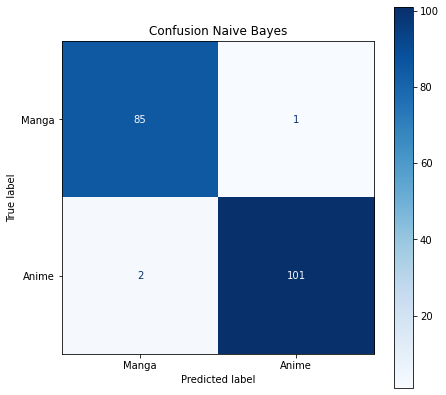

In [475]:
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_estimator(gs_NB, X_lem_test, y_lem_test, display_labels = ['Manga', 'Anime'], cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Naive Bayes")
plt.show()

In [1181]:
# Speend comparison

# Data Analysis

In [981]:
log_pipe = make_pipeline(TfidfVectorizer(max_features = 10000, ngram_range=(2, 2)), LogisticRegression())

In [982]:
log_pipe.fit(X_train, y_train)

log_pipe.score(X_test, y_test)

coefs = log_pipe['logisticregression'].coef_

bigram_coefs = pd.DataFrame({'words': log_pipe['tfidfvectorizer'].get_feature_names_out(), 'coef': coefs[0]}).sort_values(by= 'coef')
bigram_coefs

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(2, 2))),
                ('logisticregression', LogisticRegression())])

In [1001]:
bigram_coefs.iloc[-10:, :]

,words,coef
671,anime where,0.491792
4743,myanimelist net,0.502537
3323,https myanimelist,0.502537
3389,if you,0.510540
3328,https www,0.527191
3476,in the,0.527477
6295,should watch,0.611981
7888,violet evergarden,0.724012
352,an anime,1.019690
7617,to watch,1.388300


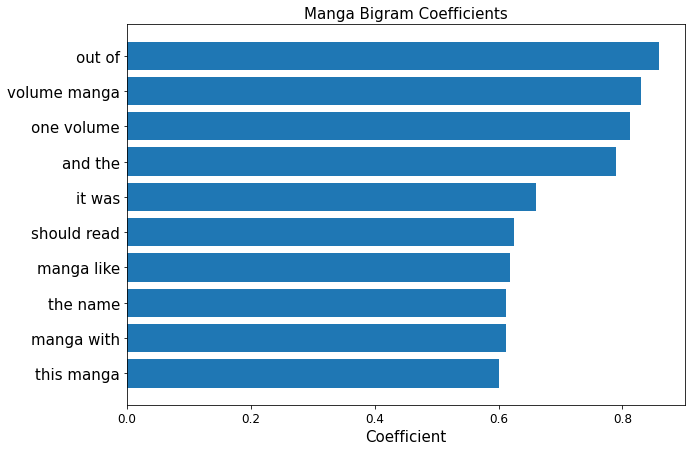

In [1169]:
plt.figure(figsize=(10,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Coefficient', fontsize=15)
plt.barh(bigram_coefs.iloc[:10, :]['words'], sorted(bigram_coefs.iloc[:10, :]['coef']*-1))
plt.title("Manga Bigram Coefficients", fontsize=15);

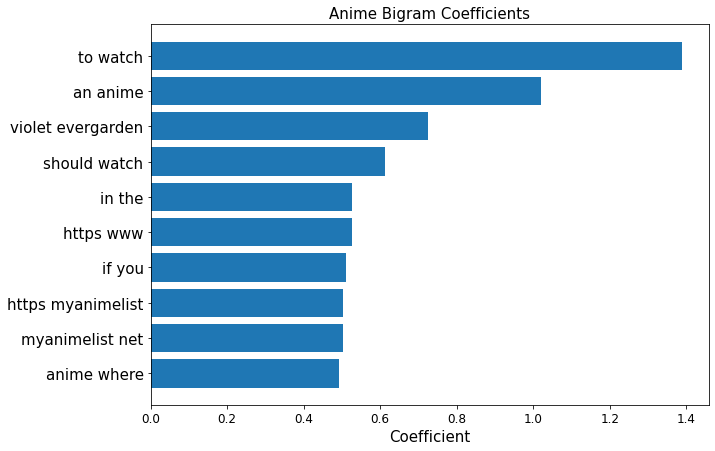

In [1170]:
plt.figure(figsize=(10,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel('Coefficient', fontsize=15)
plt.barh(bigram_coefs.iloc[-10:, :]['words'], bigram_coefs.iloc[-10:, :]['coef'])
plt.title("Anime Bigram Coefficients", fontsize=15);

In [827]:
bigram_df = pd.DataFrame(b_pipe[0].fit_transform(X_train, y_train).toarray(), columns = b_pipe['tfidfvectorizer'].get_feature_names_out())
bigram_df

,016 forgot,29 https,37987 anilist,41450 anime,4xjqqrqtghy https,500 anime,81193214 information,90s ideas,absolutely destroyed,abuser girl,...,yesterday saying,yggdrasil pact,younger loved,youpoll 66183,youtu 4xjqqrqtghy,youtube channel,youtube com,zero 016,zero overrated,zombies definitely
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.167176
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.528037,0.0,0.0,0.000000
562,0.0,0.0,0.0,0.0,0.229416,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.458831,0.0,0.000000,0.0,0.0,0.000000
563,0.0,0.0,0.0,0.0,0.000000,0.399485,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
564,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


Decision tree models give high scores on accuracy. I will use a simple Decision Tree Classifier so I can see how it's sorting data in it's nodes.

In [1140]:
dc_pipe = make_pipeline(CountVectorizer(max_features = 1000), DecisionTreeClassifier())

In [1141]:
dc_pipe.fit(X_lem_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=1000)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [1142]:
dc_pipe.score(X_lem_test, y_test)

0.9735449735449735

In [1152]:
dc_pipe

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=1000)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [1174]:
dc_pipe.score(X_lem_train, y_train)

0.9946996466431095

In [2]:
plt.figure(figsize=(25,20)) 
plot_tree(dc_pipe['decisiontreeclassifier'], 
                feature_names=dc_pipe['countvectorizer'].get_feature_names_out(),  
                filled=True);

NameError: name 'plt' is not defined

I will now test the Logistic Regressor Classifier after removing words that making classification easy.

In [1208]:
pipe4 = make_pipeline(TfidfVectorizer(), 
                      BaggingClassifier())

In [1209]:
pipe4.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('baggingclassifier', BaggingClassifier())])

In [1210]:
pipe4.score(X_lem_test, y_lem_test)

0.9788359788359788

In [1218]:
# will add 'anime' and 'manga' to stopwords to see accuracy
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append(['manga', 'anime'])

In [1219]:
df_lem[df_lem['selftext'].str.contains('anim')].head(2)

,subreddit,selftext,title,Bigrams,Most frequent Bigram
0,1,know title know opening song main character si...,looking anime,"[looking anime, anime know, know title, title ...",nai nai
2,1,here's mal list reference http myanimelist net...,i'm bored looking anime watch keep going,"[i'm bored, bored looking, looking anime, anim...",i'm bored


In [1223]:
stopwords

<WordListCorpusReader in 'C:\\Users\\marcj\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [1254]:
# Code to lemmatize and remove stop words and anime and manga. Originally by Katie Sylvia
def lem_cleaner2(comment):
    # Set token & instantiate Lem
    lemmatizer = WordNetLemmatizer()
    my_tokenizer = RegexpTokenizer("[\w']+|\$[\d\.]+") 

    
    # split string into a word list in lower case
    words = my_tokenizer.tokenize(comment.lower())

    # remove stop words and custom words from list
    stop_word_list = stopwords.words('english')
    extra_words = ['mangazuki', 'mangas','manga','myanimelist','animelist', 'anime']
    for i in extra_words:
        stop_word_list.append(i)
    no_stops = [i for i in words if i not in stop_word_list]

    # Lemmatize each word in list 
    comm_lem = [lemmatizer.lemmatize(i) for i in no_stops]

    # Put words back together
    return " ".join(comm_lem)

In [1247]:
df_lem['selftext'] = df_lem['selftext'].map(lem_cleaner2)
# apply stemming function to data title column
df_lem['title'] = df_lem['title'].map(lem_cleaner2)

In [1248]:
df_lem[df_lem['selftext'].str.contains('manga')]

,subreddit,selftext,title,Bigrams,Most frequent Bigram
466,0,hello remember exact plot part contain spoiler...,looking name,"[looking manga, manga name, name hello, hello ...",looking manga
496,0,hello remember exact plot part contain spoiler...,looking name,"[looking manga, manga name, name hello, hello ...",looking manga
512,0,hi saw someone post shueisha thought ask youtu...,shueisha took youtube channel,"[shueisha took, took youtube, youtube channel,...",youtube channel
527,0,hello remember exact plot part contain spoiler...,looking name,"[looking manga, manga name, name hello, hello ...",looking manga
543,0,hi saw someone post shueisha thought ask youtu...,shueisha took youtube channel,"[shueisha took, took youtube, youtube channel,...",youtube channel
555,0,hello remember exact plot part contain spoiler...,looking name,"[looking manga, manga name, name hello, hello ...",looking manga
571,0,hi saw someone post shueisha thought ask youtu...,shueisha took youtube channel,"[shueisha took, took youtube, youtube channel,...",youtube channel
584,0,hello remember exact plot part contain spoiler...,looking name,"[looking manga, manga name, name hello, hello ...",looking manga
600,0,hi saw someone post shueisha thought ask youtu...,shueisha took youtube channel,"[shueisha took, took youtube, youtube channel,...",youtube channel
631,0,hi saw someone post shueisha thought ask youtu...,shueisha took youtube channel,"[shueisha took, took youtube, youtube channel,...",youtube channel


In [1249]:
df_lem[df_lem['selftext'].str.contains('anime')]

,subreddit,selftext,title,Bigrams,Most frequent Bigram
16,1,komi san wa comyushou desu episode 1 alternati...,komi san wa comyushou desu episode 1 discussion,"[komi san, san wa, wa comyushou, comyushou des...",komi san
40,1,episode 13 we'll go another journey someday pr...,sora yori mo tooi basho place universe rewatch...,"[sora yori, yori mo, mo tooi, tooi basho, bash...",place universe
41,1,episode 13 we'll go another journey someday pr...,sora yori mo tooi basho place universe rewatch...,"[sora yori, yori mo, mo tooi, tooi basho, bash...",place universe
51,1,sekai saikou ansatsusha isekai kizoku ni tense...,sekai saikou ansatsusha isekai kizoku ni tense...,"[sekai saikou, saikou ansatsusha, ansatsusha i...",finest assassin
60,1,shin nakama ja nai yuusha party wo oidasareta ...,shin nakama ja nai yuusha party wo oidasareta ...,"[shin nakama, nakama ja, ja nai, nai yuusha, y...",shin nakama
65,1,vote female category http animebracket com r b...,summer 2021 best seiyuu voice actor voice actr...,"[summer 2021, 2021 best, best seiyuu, seiyuu v...",com r
85,1,shin nakama ja nai yuusha party wo oidasareta ...,shin nakama ja nai yuusha party wo oidasareta ...,"[shin nakama, nakama ja, ja nai, nai yuusha, y...",shin nakama
90,1,vote female category http animebracket com r b...,summer 2021 best seiyuu voice actor voice actr...,"[summer 2021, 2021 best, best seiyuu, seiyuu v...",com r
313,1,komi san wa comyushou desu episode 1 alternati...,komi san wa comyushou desu episode 1 discussion,"[komi san, san wa, wa comyushou, comyushou des...",komi san
358,1,komi san wa comyushou desu episode 1 alternati...,komi san wa comyushou desu episode 1 discussion,"[komi san, san wa, wa comyushou, comyushou des...",komi san


results are much less than before words related to anime and manga were removed

In [1250]:
# Lemmatized X data is text in title column plus text in selftext column
X_lem = df_lem['title'] + " " + df_lem['selftext']
# target is which subreddit text originates from, 1 for r/anime, 0 for r/manga
y = df['subreddit']

In [1251]:
X_lem_train, X_lem_test, y_lem_train, y_lem_test = train_test_split(X_lem, y, stratify=y)

In [1252]:
pipe4.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('baggingclassifier', BaggingClassifier())])

In [1253]:
pipe4.score(X_lem_test, y_lem_test)

0.9523809523809523

In [1255]:
log_pipe.fit(X_lem_train, y_lem_train)
log_pipe.score(X_lem_test, y_lem_test)

0.9576719576719577

In [1256]:
coefs = log_pipe['logisticregression'].coef_
bigram_coefs = pd.DataFrame({'words': log_pipe['tfidfvectorizer'].get_feature_names_out(), 'coef': coefs[0]}).sort_values(by= 'coef')
bigram_coefs

,words,coef
3557,one volume,-0.787049
314,anyone know,-0.710332
1910,girl get,-0.630785
2312,http youtu,-0.581326
5889,youtu 4xjqqrqtghy,-0.581326
...,...,...
787,character would,0.604223
5898,zero two,0.623927
2304,http net,0.698126
3281,nai nai,0.748579


# Results

The Average length of a message from r/anime is 270 characters, shorter than the average length from r/manga at 373.

### Scoring Summary

The best performers are 
- Logistic Regression -- CountVectorizer -- Uncleaned words <br>
'Accuracy is 0.9894179894179894, F1 Score is 0.9901960784313726, Balanced Accuracy is 0.9902912621359223' 


- Extra Trees -- CountVectorizer -- Uncleaned words <br>
'Accuracy is 0.9841269841269841, F1 Score is 0.9853658536585367, Balanced Accuracy is 0.9844773086475502'


- Random Forests -- TfidfVectorizer -- Lemmatized words <br>
'Accuracy is 0.9894179894179894, F1 Score is 0.9901960784313726, Balanced Accuracy is 0.9902912621359223'


- Bagging -- TfidfVectorizer -- Lemmatized words <br>
'Accuracy is 0.9841269841269841, F1 Score is 0.9855072463768114, Balanced Accuracy is 0.983517724091217'

The only model to reach 100% accuracy used TfidfVectorizer transformer, BaggingClassifier as classifier, and Lemmatized word in X data.

The Naive Bayes classifier give a slightly less accurate score on average.

Even with the words 'mangazuki', 'mangas', 'manga', 'myanimelist', 'animelist', and 'anime' removed, the BaggingClassifier still has a 95% accuracy.

### Evaluation and Conceptual Understanding

Posts on r/manga tend to be longer than on r/anime, however r/anime has more posts over 1000 characters. <br>
Posts on r/anime are more likely to be very low or very high, whereas on r/manga the length is more smoothly distributed.

r/anime has bigrams like 'original japanese' and r/manga has 'help finding'. It happens more often on r/manga that someone is looking for a what manga a certain scene or image originates from. Posters on r/anime are more likely to talk about Violet Evergarden or talk about the original japenese dub versus the english dub of an anime. Popular Mangas that have been turned into an anime like Furare Girl are mentioned on both subreddits. 

The GridSearch accuracy score is within a few percentage points of the defualt setting. The Grid Searching doesn't seem to make a significant difference. The accuracy score of the function using just a pipeline fluctuate between .96 and .98, and the GridSearch scores fluctuate between .97 and .99. Stemmed word vs. Lemmatized words vs. unlceaned words are also pretty close withink about .03% of each other.

After give-away words related to 'anime and 'manga' were removed, the phrases corresponding to r/anime are 'Violet Evergarden', and 'character would'. For r/manga it is 'one volume', and 'anyone know'. Some of these were on the bigram list and show the different sort of questions people tend to ask on the different subreddits. This shows that machine learning classifiers are very good seeing word patterns in text that aren't obvious.

### Conclusion and Reccomendations

Banks and other financial institutions have a lot to gain by automating part of their contract review process. If you start internally developing machine learning software and tailor it to their needs it would be even more accurate than what’s commercially available. A person with expertise in the field still needs to work with these models as they are not perfect, but in the long run they can save money and eliminate some repetitive tasks.